# Periodic Model Violations: Asymmetric Peaks in the Frequency Domain

In this set of simulations, we will test FOOOF's performance across power spectra that violate some of the assumptions of the FOOOF model, in particular regarding the periodic components.

In this example, we will explore the case of asymmetric peaks, in the frequency domain. 

Note that these asymmetric peaks were simulated directly in the frequency domain. It is unclear what properties of data, in the time domain, lead to asymmetric peaks in the frequency domain. This could arise, for example, from variation in the peak frequency of the oscillation over time. 

### Notes on asymmetric peaks

Asymmetric peaks, in the frequency domain, can be reasonably well approximated by fitting symmetric Gaussians, in the sense of capturing the overall model, and capturing the peak center frequency and power. The fit does often include fitting additional peaks, to capture the asymmetric aspects of the peaks, so the model is not ideal, and bandwidth estimates of individual peaks may not be representative. 

In [1]:
import numpy as np

from fooof import FOOOF, FOOOFGroup, fit_fooof_group_3d
from fooof.sim.gen import *
from fooof.plts import plot_spectrum

In [2]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from settings import F_RANGE, F_RES
from sims import *
from plts import *
from utils import *
from analysis import *

## Settings

In [3]:
# Set random seed
import random
random.seed(333)

In [4]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [5]:
# Analysis Settings
SAVE_FIG = False
GEN_SIMS = True

## EXAMPLE

In [6]:
# Create frequency vector
freqs = np.arange(*F_RANGE, F_RES)

# Define settings for examples
cf1, cf2 = 10, 25
pw1, pw2 = 0.5, 0.3
scale = 2.0
skew = 10

nlv = 0.0
aperiodic_params = [1, 1]

### Example Asymetric Peaks

In [7]:
# Generate some example skewed peaks
peak_vals_1 = gen_skew_peaks(freqs, [[cf1, pw1, scale, skew]])
peak_vals_2 = gen_skew_peaks(freqs, [[cf1, pw1, scale, skew],
                                     [cf2, pw2, scale, skew]])

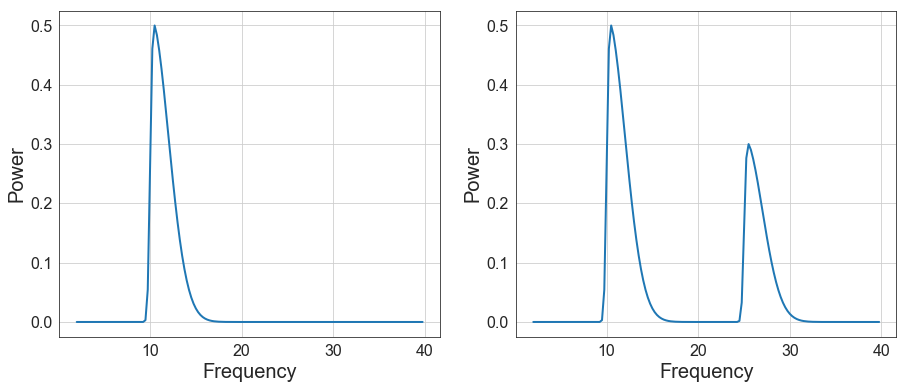

In [8]:
_, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_spectrum(freqs, peak_vals_1, ax=axes[0])
plot_spectrum(freqs, peak_vals_2, ax=axes[1])

### Example Spectra with Asymmetric Peaks

In [9]:
# Generate an example power spectrum, with 1 skewed peak
spectrum_vals_1 = gen_power_vals_fn(freqs,
                                    ap_kwargs={'aperiodic_params' : aperiodic_params},
                                    pe_kwargs={'params' : [[cf1, pw1, scale, skew]]},
                                    noise_kwargs={'nlv' : nlv},
                                    pe_func=gen_skew_peaks)

In [10]:
# Generate an example power spectrum, with 2 skewed peaks
spectrum_vals_2 = gen_power_vals_fn(freqs,
                                    ap_kwargs={'aperiodic_params' : aperiodic_params},
                                    pe_kwargs={'params' : [[cf1, pw1, scale, skew],
                                                           [cf2, pw2, scale, skew]]},
                                    noise_kwargs={'nlv' : nlv},
                                    pe_func=gen_skew_peaks)

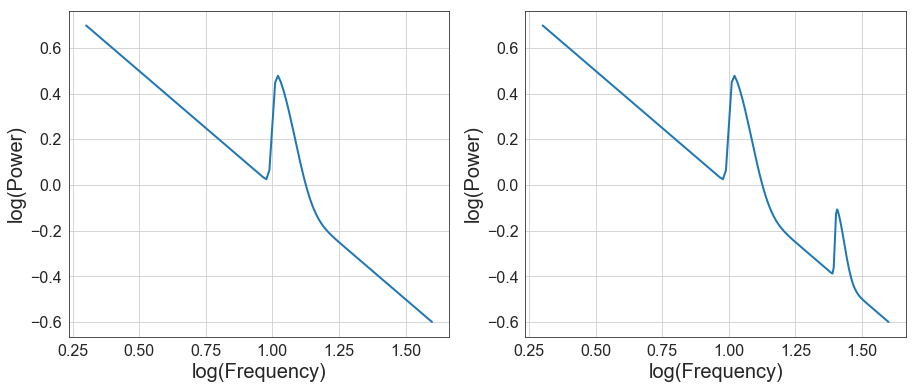

In [11]:
# Plot the example power spectra, with skewed peaks
_, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_spectrum(freqs, spectrum_vals_1, log_powers=True, log_freqs=True, ax=axes[0])
plot_spectrum(freqs, spectrum_vals_2, log_powers=True, log_freqs=True, ax=axes[1])

### Examples of fitting asymetric spectra

In [12]:
# Initialzie FOOOF models to fit examples
fm1 = FOOOF()
fm2 = FOOOF()

In [13]:
# Fit example data
fm1.fit(freqs, spectrum_vals_1)
fm2.fit(freqs, spectrum_vals_2)

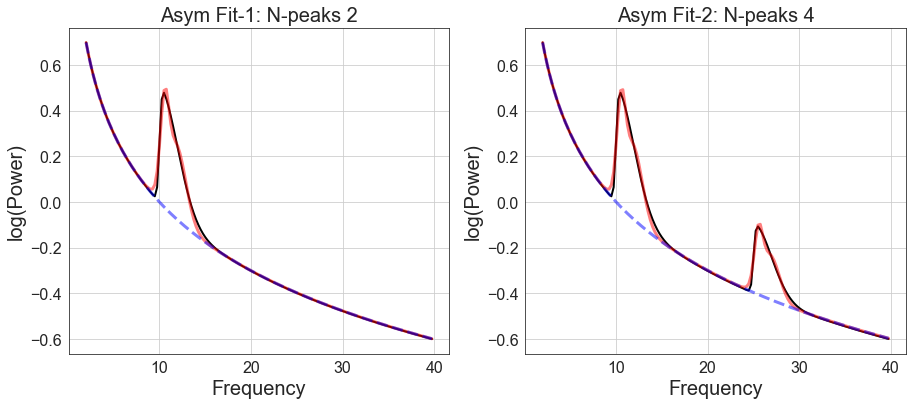

In [14]:
# Plot model fits for the example data
_, axes = plt.subplots(1, 2, figsize=(15, 6))
fm1.plot(add_legend=False, ax=axes[0])
axes[0].set_title('Asym Fit-1: N-peaks {}'.format(fm1.n_peaks_), {'fontsize' : 20})
fm2.plot(add_legend=False, ax=axes[1])
axes[1].set_title('Asym Fit-2: N-peaks {}'.format(fm2.n_peaks_), {'fontsize' : 20});

### Notes on Examples

Note in the examples above, the overall fits look really quite good!

However, one thing to keep in mind, which isn't necessarily totally visible from just the plots themselves is that the model deals with the skewness of the peaks by fitting extra peaks to capture the asymmetric aspects of the peaks. To highlight this, in the titles we have plotted the number of fit peaks in the model - which shows that each asymmetric peak is paramterized by at least two Guassians in the model. 

### Simulate Data

In [15]:
# Set the number of PSDs - this is per n_oeak condition
n_psds = 1000

# Set the noise levels to use
skews = [0, 5, 10, 25, 50]

# Set the noise level to use
nlv = 0.01

# # Use generators to sample peak & aperiodic parameters
peaks = gen_peak_def(1)
aps = gen_ap_def()

In [16]:
# Get data sizes
n_skews = len(skews)
n_freqs = len(freqs)

In [17]:
# Generate or load power spectra
data_name = 'mvpe_apeak_sims'

if GEN_SIMS:
    
    # Initialize data stores
    psds = np.empty(shape=[n_skews, n_psds, n_freqs])
    sim_params = [[None] * n_psds] * n_skews

    # Generate simulated power spectra
    for sk_ind, skew in enumerate(skews):

        for psd_ind in range(n_psds):
            
            # Sample an aperiodic parameter definition
            cur_aps = next(aps)
            
            # Sample an periodic parameter definition
            #  This grabs a definition from the peak definition, and adds a skew value
            #  Note: cur_peaks needs to end up as an embedded list
            cur_peaks = [next(peaks)]
            cur_peaks[0].append(skew)
            
            # Collect simulation parameters
            sim_params[sk_ind][psd_ind] = SimParams(cur_aps, cur_peaks, nlv)
            
            psds[sk_ind, psd_ind, :] = gen_power_vals_fn(
                freqs, ap_kwargs = {'aperiodic_params' : cur_aps},
                pe_kwargs = {'params' : cur_peaks},
                noise_kwargs = {'nlv' : nlv},
                pe_func = gen_skew_peaks)
    
    # Save out generated simulated data & parameter definitions
    save_sim_data(data_name, freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(data_name)           
        
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 1000, 152)


In [18]:
# Extract ground truth values
peak_truths, ap_truths = get_ground_truth(sim_params)

### Fit Power Spectra with FOOOF

In [19]:
# Initialize FOOOFGroup to test with
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6,
                min_peak_height=0.1, verbose=False)

# Print out settings used for fitting simulated power spectra
fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 6]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.1                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [20]:
# Fit power spectra - same FOOOF settings across each group of simulated power spectra
fgs = fit_fooof_group_3d(fg, freqs, psds)

### Extract FOOOF fit Data

In [21]:
# Extract data of interest from FOOOF fits
peak_fits, ap_fits, err_fits, r2_fits, n_fit_peaks = get_fit_data(fgs)

In [22]:
# Calculate errors
peak_errors = calc_errors(peak_truths[:, :, 0:3], peak_fits)
ap_errors = calc_errors(ap_truths, ap_fits)

In [23]:
# Pull out error per peak parameter
cf_errors = peak_errors[:, :, 0]
pw_errors = peak_errors[:, :, 1]

# Pull out error per aperiodic parameter
off_errors = ap_errors[:, :, 0]
exp_errors = ap_errors[:, :, 1]

In [24]:
# Get count of relation between number of simualated and fit peaks
n_peak_counter = count_peak_conditions(n_fit_peaks, skews)

### Check Average Errors & Stats

In [25]:
# Check overall fit quality
temp = r2_fits.flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.9714 	0.9998
Median  R^2: 	0.9990


In [26]:
# Collect data together
datas = {
    'CF' : cf_errors,
    'PW' : pw_errors,
    'OFF' : off_errors,
    'EXP' : exp_errors,
    'ERR' : err_fits,
    'R^2' : r2_fits
}

In [27]:
# Print out the average error for each parameter
#   Also prints out the average model error and R^2 per noise level
for label, data in datas.items():
    print(label)
    print('\t', np.nanmedian(data, 1))

CF
	 [6.99091278 6.96450281 7.1996716  6.99194477 0.59842297]
PW
	 [0.06053209 0.06863783 0.07448177 0.08495223 0.02953806]
OFF
	 [0.00423147 0.00261115 0.00263153 0.00261913 0.00252612]
EXP
	 [0.50054993 0.50090315 0.50127008 0.50160478 0.00200999]
ERR
	 [0.00818928 0.00909245 0.0092037  0.00940862 0.00934536]
R^2
	 [0.99922453 0.99902316 0.99891061 0.99882001 0.99885328]


### Create Plots

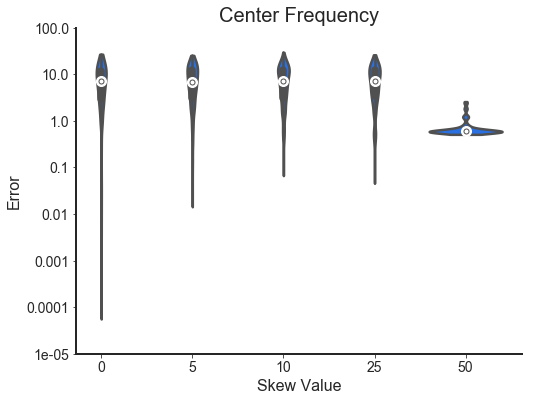

In [28]:
# Plot the error of peak center frequency reconstruction
plot_errors_violin(cf_errors, 'Center Frequency',
                   plt_log=True, x_axis='skew',
                   save_fig=SAVE_FIG, save_name='1Peak-CF')

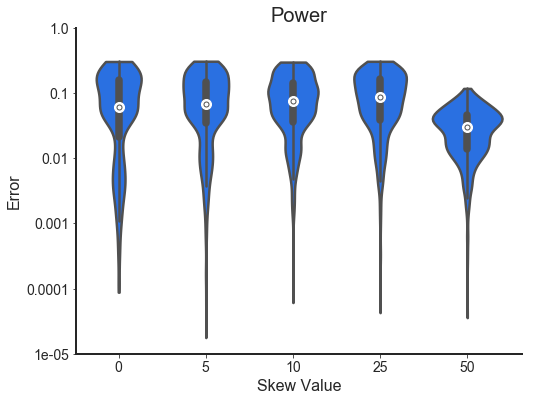

In [29]:
# Plot the error of peak power reconstruction
plot_errors_violin(pw_errors, 'Power',
                   plt_log=True, x_axis='skew',
                   save_fig=SAVE_FIG, save_name='1Peak-PW')

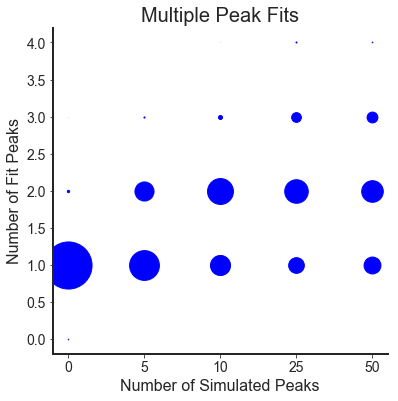

In [30]:
# Plot the correspondance between number of simulated peaks & skew value
plot_n_peaks_bubbles(n_peak_counter, ms_val=10)

#### Aperiodic Components

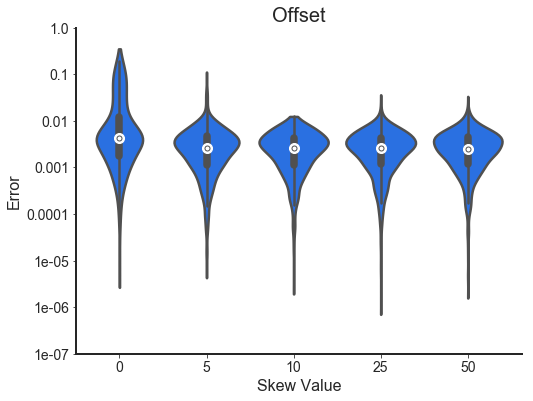

In [31]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(off_errors, 'Offset',
                   plt_log=True, x_axis='skew',
                   save_fig=SAVE_FIG, save_name='1Peak-Off')

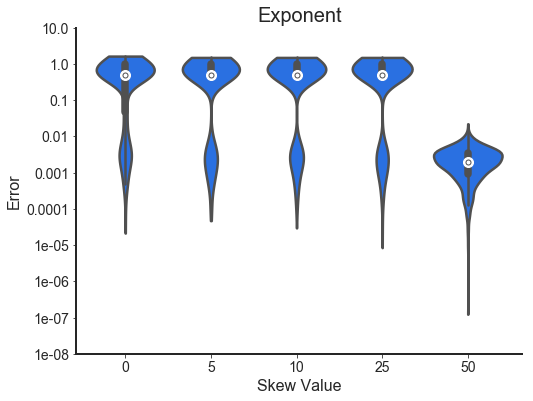

In [32]:
# Plot the error of aperiodic exponent reconstruction
plot_errors_violin(exp_errors, 'Exponent',
                   plt_log=True, x_axis='skew',
                   save_fig=SAVE_FIG, save_name='1Peak-Exp')

#### Goodness of Fit Measures

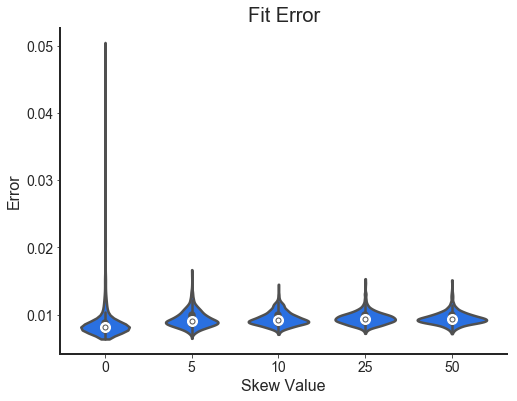

In [33]:
# Plot the amount of error across noise levels
plot_errors_violin(err_fits, 'Fit Error', plt_log=False,
                   x_axis='skew',
                   save_fig=SAVE_FIG, save_name='1Peak-Err')

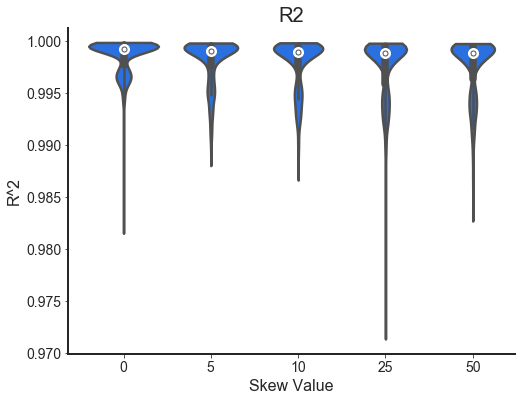

In [34]:
# Plot the goodness-of-fit (R^2) across noise levels
plot_errors_violin(r2_fits, 'R2', y_label='R^2', x_axis='skew', plt_log=False)

### Example FOOOF Fits

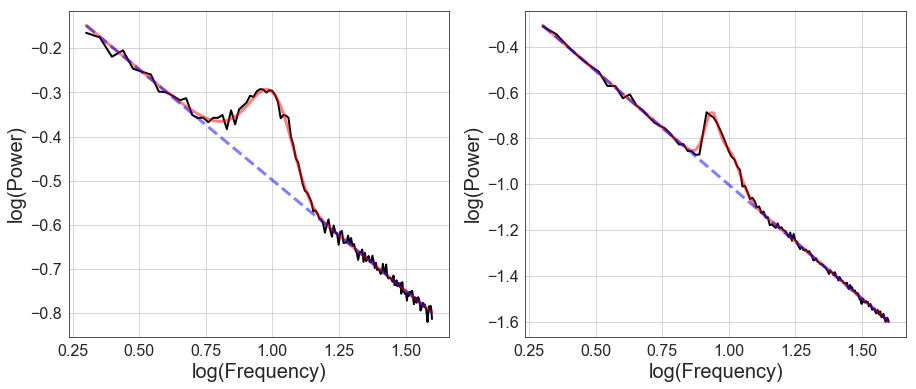

In [35]:
_, axes = plt.subplots(1, 2, figsize=[15, 6])

# Grab example case of no knee
fm1 = fgs[0].get_fooof(0, True)
fm1.plot(plt_log=True, add_legend=False, ax=axes[0])

# Grab example case of highest value knee
fm2 = fgs[-1].get_fooof(0, True)
fm2.plot(plt_log=True, add_legend=False, ax=axes[1])